# Backend API Data Consumption

This notebook demonstrates how to consume the AWS Meteo Backend API to retrieve and visualize STI indices. It follows the flow: List Runs -> Get Steps -> Request Subset.

In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

BASE_URL = "http://localhost:8000"

## 1. List Available Runs

In [6]:
response = requests.get(f"{BASE_URL}/sti/runs")
if response.status_code == 200:
    runs = response.json().get("runs", [])
    print("Available Runs:", runs)
else:
    print("Error listing runs:", response.text)
    runs = []

Available Runs: ['2025111500', '2025112300', '2025112900', '2025121200']


## 2. Select Latest Run and Get Steps

In [7]:
if runs:
    # Select the latest run or a specific one
    selected_run = runs[-1]
    print(f"Selected Run: {selected_run}")
    
    response = requests.get(f"{BASE_URL}/sti/{selected_run}/steps")
    if response.status_code == 200:
        steps = response.json().get("steps", [])
        print("Available Steps:", steps)
    else:
        print("Error listing steps:", response.text)
        steps = []
else:
    print("No runs to select from.")
    steps = []

Selected Run: 2025121200
Available Steps: ['048']


## 3. Request Subset (GeoJSON-like Payload)

In [8]:
if steps:
    selected_step = steps[0] # First step
    print(f"Requesting subset for Run: {selected_run}, Step: {selected_step}")
    
    # Chile-ish bounds
    params = {
        "lat_min": -56.0,
        "lat_max": -17.0,
        "lon_min": -76.0,
        "lon_max": -66.0
    }
    
    url = f"{BASE_URL}/sti/{selected_run}/{selected_step}/subset"
    try:
        r = requests.get(url, params=params)
        if r.status_code == 200:
            data = r.json()
            print("Subset retrieved successfully.")
            print(f"Keys: {data.keys()}")
            
            lats = np.array(data["latitudes"])
            lons = np.array(data["longitudes"])
            sti = np.array(data["sti"])
            
            print(f"Total Data Points: {len(sti)}")
            print(f"Min STI: {sti.min()}, Max STI: {sti.max()}")
            
        else:
            print(f"Failed to retrieve subset. Status: {r.status_code}")
            print(r.text[:500])
            data = None
            
    except Exception as e:
        print(f"Request failed: {e}")
        data = None
else:
    print("Skipping subset request.")

Requesting subset for Run: 2025121200, Step: 048
Subset retrieved successfully.
Keys: dict_keys(['run', 'step', 'latitudes', 'longitudes', 'sti'])
Total Data Points: 6437
Min STI: -20688782.0, Max STI: 3023162.75


## 4. Visualize Data
Simple scatter plot to verify geographic distribution.

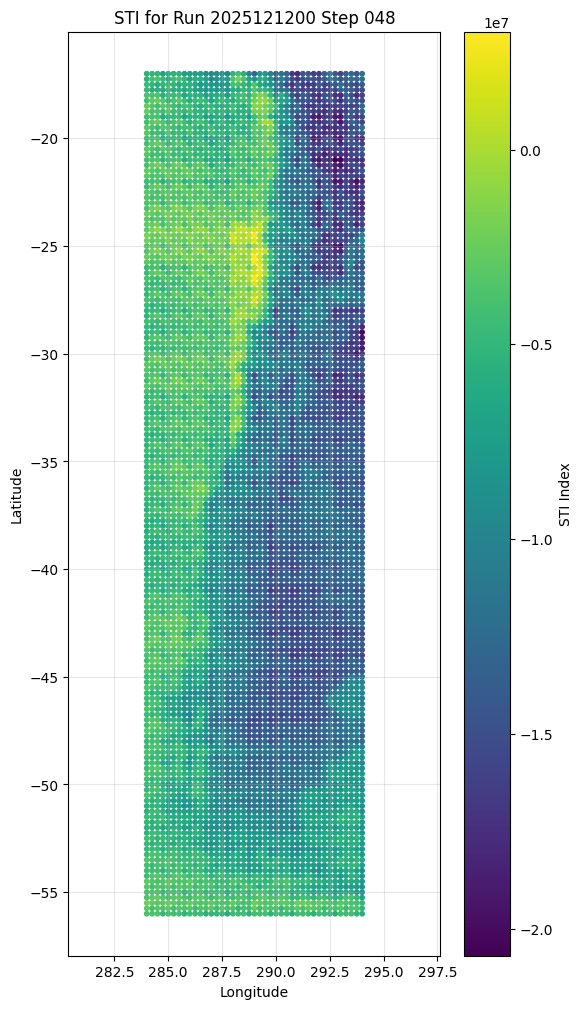

In [9]:
if data and len(data.get("sti", [])) > 0:
    plt.figure(figsize=(6, 12))
    sc = plt.scatter(lons, lats, c=sti, cmap='viridis', s=10)
    plt.colorbar(sc, label='STI Index')
    plt.title(f"STI for Run {selected_run} Step {selected_step}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()
else:
    print("No data to plot.")